# Imports
Import libraries and write settings here.

In [1]:
# Notebooks specific imports ########################################
from IPython import get_ipython

ipython = get_ipython()
# Expand notebook display
from IPython.display import display, HTML

display(HTML("<style>.container { width:80% !important; }</style>"))
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
# autoreload extension
if "autoreload" not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2
from tqdm.notebook import tqdm
# End notebooks specific imports ####################################

# Basic useful imports
import yaml
from pathlib import Path
from pprint import pprint
import h5py

# Data manipulation
import numpy as np
from scipy.spatial import cKDTree

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt

# From alens_analysis
import alens_analysis as aa
import alens_analysis.chromatin as aac

import torch

torch.__version__
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"torch device: {device}")

# Locations
alens_data_path = Path.home() / "ceph/DATA/Motor_Inference/IsoNemTesting"

graph_sty = {
    "axes.titlesize": 20,
    "axes.labelsize": 24,
    "lines.linewidth": 2,
    "lines.markersize": 2,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "font.size": 20,
    "font.sans-serif": "Helvetica",
    "text.usetex": False,
    "mathtext.fontset": "cm",
}
plt.style.use(graph_sty)

torch device: cuda


In [2]:
from scipy.spatial.transform import Rotation as R


def rotation_matrix_from_vectors(vec1, vec2):
    """Find the rotation matrix that aligns vec1 to vec2
    :param vec1: A 3d "source" vector
    :param vec2: A 3d "destination" vector
    :return mat: A transform matrix (3x3) which when applied to vec1, aligns it with vec2.
    """
    # Normalize vectors
    vec1 = vec1 / np.linalg.norm(vec1)
    vec2 = vec2 / np.linalg.norm(vec2)

    # Compute the cross product and dot product
    cross_prod = np.cross(vec1, vec2)
    dot_prod = np.dot(vec1, vec2)

    # Compute the rotation angle
    angle = np.arccos(dot_prod)

    # Compute the rotation axis
    axis = cross_prod / np.linalg.norm(cross_prod)

    # Use scipy to compute the rotation matrix
    rotation_vector = axis * angle
    rotation = R.from_rotvec(rotation_vector)
    rotation_matrix = rotation.as_matrix()

    return rotation_matrix


def filter_ghost_particles(com_arr, n_arr):
    ghost_vec = np.array([0, 0, 0])
    mask = np.all(com_arr[:, :] == ghost_vec, axis=1)
    return com_arr[~mask], n_arr[~mask]


def zrho_corr_new(n_arr, com_arr, time=None, distance=1.0, boxsize=None):
    if time is None:
        positions, normals = filter_ghost_particles(com_arr, n_arr)
        # normal vector of segments, centerpoints, time and cutoff distcnce
    else:
        positions, normals = filter_ghost_particles(
            com_arr[:, :, time], n_arr[:, :, time]
        )
    print(positions.shape)
    tree = cKDTree(positions, boxsize=boxsize)
    # pairs = tree.query_ball_tree(tree, r=distance)
    # for pair in pairs:
    #     print(len(pair))

    zpos = []
    rhopos = []
    zvec = np.array([0, 0, 1])
    rot_neigh_pos_list = []
    for cur_seg, pos in enumerate(positions):
        neighbor_inds = tree.query_ball_point(pos, r=distance)
        print(neighbor_inds)
        n_vec = normals[cur_seg, :]  # Normal vector of current segment
        # neighbor_inds.remove(cur_seg) # Don't count self distances
        neigh_pos = positions[neighbor_inds, :] - positions[cur_seg, :]

        # Rotation matrix that transforms current segments orientation to zvec
        rot_mat = rotation_matrix_from_vectors(n_vec, zvec)
        # Rotate all neighbors to align with current zvec
        rot_neigh_pos_list += [np.einsum("ij,kj->ki", rot_mat, neigh_pos)]

    rot_neigh_pos_arr = np.vstack(rot_neigh_pos_list)
    rhopos = np.linalg.norm(rot_neigh_pos_arr[:, :2], axis=1)
    zpos = rot_neigh_pos_arr[:, 2]
    return zpos, rhopos

In [3]:
print("###### RunConfig dictionary ########")
# Load in the yaml dictionary
data_path = alens_data_path / "NemN8000ld5rho.4dte-5/simulations/dt1e-05"
data_path.exists()
run_config_str = data_path / "RunConfig.yaml"
param_dict = yaml.load(run_config_str.open(), Loader=yaml.FullLoader)
pprint(param_dict)
print(" The viscosity of the fluid is", param_dict["viscosity"], "pN s/um^2")

###### RunConfig dictionary ########


True

{'KBT': 0.00411,
 'boundaries': None,
 'conMaxIte': 100000,
 'conResTol': '1e-5',
 'conSolverChoice': 0,
 'dt': 1e-05,
 'initBoxHigh': [0.58, 0.58, 0.58],
 'initBoxLow': [-0.58, -0.58, -0.58],
 'initCircularX': False,
 'initOrient': [0, 0, 2],
 'initPreSteps': 100,
 'linkKappa': 1000.0,
 'logLevel': 3,
 'monolayer': False,
 'rngSeed': 1234,
 'simBoxHigh': [0.58, 0.58, 0.58],
 'simBoxLow': [-0.58, -0.58, -0.58],
 'simBoxPBC': [True, True, True],
 'sylinderColBuf': 0.025,
 'sylinderDiameter': 0.025,
 'sylinderDiameterColRatio': 1.0,
 'sylinderFixed': False,
 'sylinderLength': 0.125,
 'sylinderLengthColRatio': 1.0,
 'sylinderLengthSigma': 0,
 'sylinderNumber': 8000,
 'timeSnap': 0.01,
 'timeTotal': 10.0,
 'timerLevel': 3,
 'viscosity': 0.01}
 The viscosity of the fluid is 0.01 pN s/um^2


## Nematic order testing

In [16]:
opts = lambda: None
opts.path = (
    alens_data_path / "NemN8000ld5rho.4dte-5/simulations/dt1e-05"
)  # Notice the different path
opts.analysis = "collect"
opts.analysis_dir = opts.path / "analysis"
opts.analysis_dir.mkdir(exist_ok=True)

# aa.seed_analysis(opts)

Now we wish to calculate how aligned all the filaments are over time. This is known as the nematic order and is the largest eigenvalue from the nematic order tensor 
$$Q_{\alpha\beta} = \frac{1}{N}\sum_{i=1}^N \left( \hat{u}_{i\alpha}\hat{u}_{i\beta} - \frac{1}{d}\delta_{\alpha\beta} \right)$$
where $\hat{u}_i$ is the unit vector along the filament $i$, $N$ is the number of filaments, and $d\in \{2,3\}$ is the number of spatial dimension of the system. aLENS analysis provides a function `calc_nematic_order` function to do just this.
However, because we are in a periodic box and _aLENS_ only keeps track of the tips of the filaments, we need to correct data for the periodic boundary conditions.  Luckily, aLENS analysis also provides the function `apply_pbc_to_raw_syl_data` in the helpers modules. This function takes in the raw data and the parameters of the simulation and returns the corrected data. 

No PBC needed
(8000, 9, 1003)


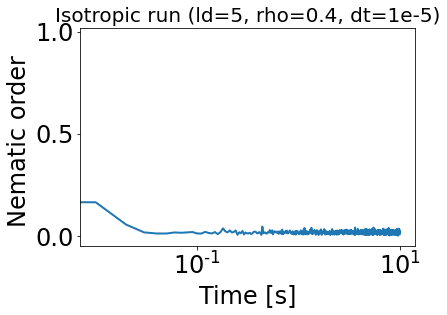

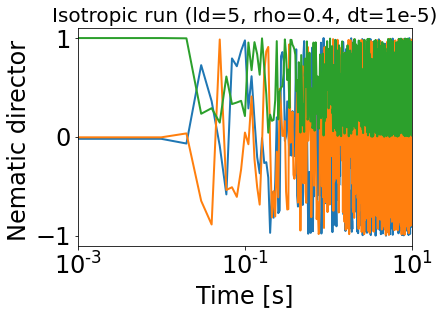

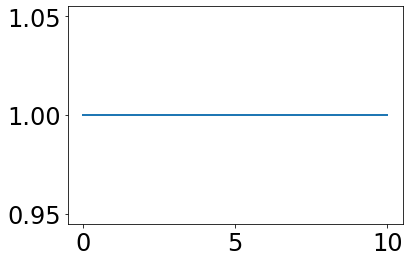

In [18]:
with h5py.File(next(opts.analysis_dir.glob("raw*.h5")), "r") as h5_data:
    param_dict = yaml.load(h5_data.attrs["RunConfig"], Loader=yaml.FullLoader)
    protein_dict = yaml.load(h5_data.attrs["ProteinConfig"], Loader=yaml.FullLoader)
    box_lower = np.array(param_dict["simBoxLow"])
    box_upper = np.array(param_dict["simBoxHigh"])
    time_arr = h5_data["time"][:]  # Load in time array, [:] loads data as numpy array
    # Load in sylinder data
    sy_dat = h5_data["raw_data/sylinders"][...]
    # aLENS analysis has some useful helper functions for post-processing data
    # This function applies periodic boundary conditions to the raw sylinder data.
    sy_dat = aa.helpers.apply_pbc_to_raw_syl_data(sy_dat, box_lower, box_upper)
    print(sy_dat.shape)

nematic_order = aa.nematic_order.calc_nematic_order(sy_dat)
_ = plt.semilogx(time_arr, nematic_order)
_ = plt.xlabel("Time [s]")
_ = plt.ylabel("Nematic order ")
_ = plt.title("Isotropic run (ld=5, rho=0.4, dt=1e-5)")
plt.show()
nematic_director_arr = aa.nematic_order.calc_nematic_director_arr(sy_dat)
_ = plt.semilogx(time_arr, nematic_director_arr[0, :])
_ = plt.semilogx(time_arr, nematic_director_arr[1, :])
_ = plt.semilogx(time_arr, nematic_director_arr[2, :])
_ = plt.xlabel("Time [s]")
_ = plt.ylabel("Nematic director ")
_ = plt.xlim(0.001, 10)
_ = plt.title("Isotropic run (ld=5, rho=0.4, dt=1e-5)")

plt.show()
plt.plot(time_arr, np.linalg.norm(nematic_director_arr, axis=0))

In [4]:
opts = lambda: None
opts.path = (
    alens_data_path / "NemN8000ld5rho.5dte-5/simulations/dt1e-05"
)  # Notice the different path
opts.analysis = "collect"
opts.analysis_dir = opts.path / "analysis"
opts.analysis_dir.mkdir(exist_ok=True)

# aa.seed_analysis(opts)

with h5py.File(next(opts.analysis_dir.glob("raw*.h5")), "r") as h5_data:
    param_dict = yaml.load(h5_data.attrs["RunConfig"], Loader=yaml.FullLoader)
    protein_dict = yaml.load(h5_data.attrs["ProteinConfig"], Loader=yaml.FullLoader)
    box_lower = np.array(param_dict["simBoxLow"])
    box_upper = np.array(param_dict["simBoxHigh"])
    time_arr = h5_data["time"][:]  # Load in time array, [:] loads data as numpy array
    # Load in sylinder data
    sy_dat = h5_data["raw_data/sylinders"][...]
    # aLENS analysis has some useful helper functions for post-processing data
    # This function applies periodic boundary conditions to the raw sylinder data.
    sy_dat_rho5_ld5 = aa.helpers.apply_pbc_to_raw_syl_data(sy_dat, box_lower, box_upper)
    # sy_dat_rho5_ld5 = torch_apply_pbc_to_raw_syl_data(sy_dat, box_lower, box_upper)

No PBC needed


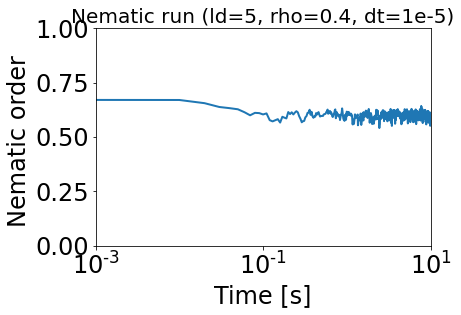

In [20]:
nematic_order = aa.nematic_order.calc_nematic_order(sy_dat)
_ = plt.semilogx(time_arr, nematic_order)
_ = plt.xlabel("Time [s]")
_ = plt.ylabel("Nematic order ")
_ = plt.ylim(0.0, 1)
_ = plt.xlim(0.001, 10)
_ = plt.title("Nematic run (ld=5, rho=0.4, dt=1e-5)")

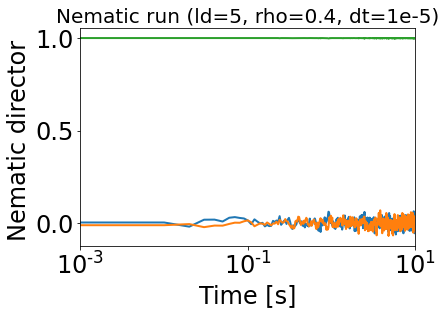

In [21]:
nematic_director_arr = aa.nematic_order.calc_nematic_director_arr(sy_dat)
_ = plt.semilogx(time_arr, nematic_director_arr[0, :])
_ = plt.semilogx(time_arr, nematic_director_arr[1, :])
_ = plt.semilogx(time_arr, nematic_director_arr[2, :])
_ = plt.xlabel("Time [s]")
_ = plt.ylabel("Nematic director ")
_ = plt.xlim(0.001, 10)
_ = plt.title("Nematic run (ld=5, rho=0.4, dt=1e-5)")

# Nematic fluctuations

In [10]:
k_points = 100
com_arr = 0.5 * (sy_dat[:, 2:5, -1] + sy_dat[:, 5:8, -1])
tcom_arr = torch.from_numpy(com_arr).to(device)
dir_arr = sy_dat[:, 5:8, -1] - sy_dat[:, 2:5, -1]

k_arr = torch.logspace(-1, 2, k_points)
tk_arr = torch.vstack([torch.zeros(k_points), k_arr, torch.zeros(k_points)]).T.to(
    device
)
tQ_arr = torch.from_numpy(aa.nematic_order.make_nematic_tensor_arr(dir_arr)).to(device)

S_arr = torch.zeros(k_points).to(device)

for i in range(k_points):
    S_arr[i] = aa.nematic_order.make_structure_factor_torch(
        tQ_arr, tcom_arr, tk_arr[i], device=device
    )

In [12]:
k_points = 100
com_arr = 0.5 * (sy_dat[:, 2:5, -1] + sy_dat[:, 5:8, -1])
tcom_arr = torch.from_numpy(com_arr).to(device)
dir_arr = sy_dat[:, 5:8, -1] - sy_dat[:, 2:5, -1]

tk_arr = torch.logspace(-1, 2, k_points)
tkx_arr = torch.vstack([tk_arr, torch.zeros(k_points), torch.zeros(k_points)]).T.to(
    device
)
tky_arr = torch.vstack([torch.zeros(k_points), tk_arr, torch.zeros(k_points)]).T.to(
    device
)
tkz_arr = torch.vstack([torch.zeros(k_points), torch.zeros(k_points), k_arr]).T.to(
    device
)
tQ_arr = torch.from_numpy(aa.nematic_order.make_nematic_tensor_arr(dir_arr)).to(device)

Sx_arr = np.zeros(k_points)
Sy_arr = np.zeros(k_points)
Sz_arr = np.zeros(k_points)

for i in range(k_points):
    Sx_arr[i] = aa.nematic_order.make_structure_factor_torch(
        tQ_arr, tcom_arr, tkx_arr[i], device=device
    )
    Sy_arr[i] = aa.nematic_order.make_structure_factor_torch(
        tQ_arr, tcom_arr, tky_arr[i], device=device
    )
    Sz_arr[i] = aa.nematic_order.make_structure_factor_torch(
        tQ_arr, tcom_arr, tkz_arr[i], device=device
    )

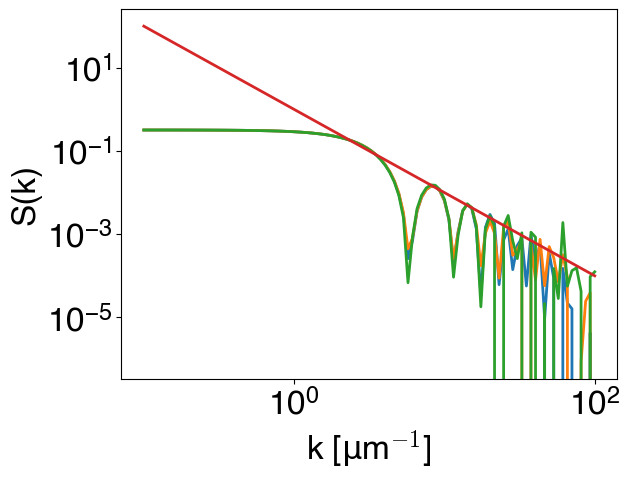

In [ ]:
_ = plt.loglog(tkx_arr[:, 0], Sx_arr)
_ = plt.loglog(tky_arr[:, 1], Sy_arr)
_ = plt.loglog(tkz_arr[:, 2], Sz_arr)
_ = plt.loglog(tkx_arr[:, 0], 1 / tkx_arr[:, 0] ** 2)

_ = plt.xlabel("k [μm$^{-1}$]")
_ = plt.ylabel("S(k)")

In [13]:
k_points = 100
com_arr = 0.5 * (sy_dat[:, 2:5, -1] + sy_dat[:, 5:8, -1])
tcom_arr = torch.from_numpy(com_arr).to(device)
dir_arr = sy_dat[:, 5:8, -1] - sy_dat[:, 2:5, -1]

tk_arr = torch.logspace(-1, 2, k_points)
tkx_arr = torch.vstack([tk_arr, torch.zeros(k_points), torch.zeros(k_points)]).T.to(
    device
)
tky_arr = torch.vstack([torch.zeros(k_points), tk_arr, torch.zeros(k_points)]).T.to(
    device
)
tkz_arr = torch.vstack([torch.zeros(k_points), torch.zeros(k_points), k_arr]).T.to(
    device
)
tQ_arr = torch.from_numpy(aa.nematic_order.make_nematic_tensor_arr(dir_arr)).to(device)
tQ_arr -= tQ_arr.mean(axis=0)

Sx_arr = np.zeros(k_points)
Sy_arr = np.zeros(k_points)
Sz_arr = np.zeros(k_points)

for i in range(k_points):
    Sx_arr[i] = aa.nematic_order.make_structure_factor_torch(
        tQ_arr, tcom_arr, tkx_arr[i], device=device
    )
    Sy_arr[i] = aa.nematic_order.make_structure_factor_torch(
        tQ_arr, tcom_arr, tky_arr[i], device=device
    )
    Sz_arr[i] = aa.nematic_order.make_structure_factor_torch(
        tQ_arr, tcom_arr, tkz_arr[i], device=device
    )

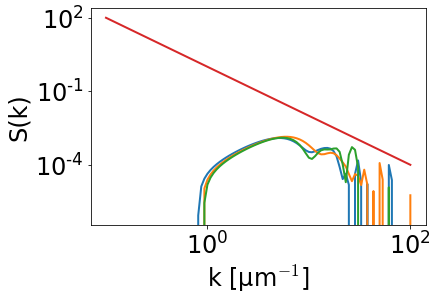

In [17]:
_ = plt.loglog(tkx_arr[:, 0].cpu(), Sx_arr)
_ = plt.loglog(tky_arr[:, 1].cpu(), Sy_arr)
_ = plt.loglog(tkz_arr[:, 2].cpu(), Sz_arr)
_ = plt.loglog(tkx_arr[:, 0].cpu(), (1.0 / tkx_arr[:, 0] ** 2).cpu())

_ = plt.xlabel("k [μm$^{-1}$]")
_ = plt.ylabel("S(k)")

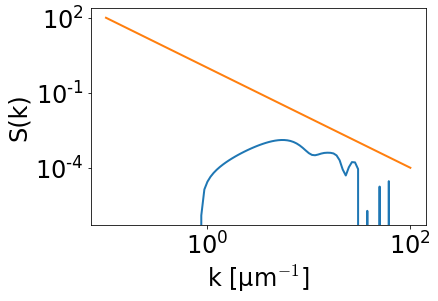

In [19]:
_ = plt.loglog(tkx_arr[:, 0].cpu(), (Sx_arr + Sy_arr + Sz_arr) / 3.0)
_ = plt.loglog(tkx_arr[:, 0].cpu(), (1.0 / tkx_arr[:, 0] ** 2).cpu())

_ = plt.xlabel("k [μm$^{-1}$]")
_ = plt.ylabel("S(k)")

In [37]:
k_points = 100
n_time_points = 2
ts_start = 100
time_step = (len(time_arr) - ts_start) // n_time_points
print(len(time_arr), time_arr[-1], time_step)

Sx_time_arr = np.zeros((k_points, n_time_points))
Sy_time_arr = np.zeros((k_points, n_time_points))
Sz_time_arr = np.zeros((k_points, n_time_points))

tk_arr = torch.logspace(-1, 2, k_points)
tkx_arr = torch.vstack([tk_arr, torch.zeros(k_points), torch.zeros(k_points)]).T.to(
    device
)
tky_arr = torch.vstack([torch.zeros(k_points), tk_arr, torch.zeros(k_points)]).T.to(
    device
)
tkz_arr = torch.vstack([torch.zeros(k_points), torch.zeros(k_points), tk_arr]).T.to(
    device
)

for i in range(n_time_points):
    print(i)
    com_arr = 0.5 * (
        sy_dat[:, 2:5, ts_start + i * time_step]
        + sy_dat[:, 5:8, ts_start + i * time_step]
    )
    tcom_arr = torch.from_numpy(com_arr).to(device)
    dir_arr = (
        sy_dat[:, 5:8, ts_start + i * time_step]
        - sy_dat[:, 2:5, ts_start + i * time_step]
    )

    tQ_arr = torch.from_numpy(aa.nematic_order.make_nematic_tensor_arr(dir_arr)).to(
        device
    )
    tQ_arr -= tQ_arr.mean(axis=0)

    for j in range(k_points):
        Sx_time_arr[j, i] = aa.nematic_order.make_structure_factor_torch(
            tQ_arr, tcom_arr, tkx_arr[j], device=device
        )
        Sy_time_arr[j, i] = aa.nematic_order.make_structure_factor_torch(
            tQ_arr, tcom_arr, tky_arr[j], device=device
        )
        Sz_time_arr[j, i] = aa.nematic_order.make_structure_factor_torch(
            tQ_arr, tcom_arr, tkz_arr[j], device=device
        )

#     Sx_avg += Sx_arr
#     Sy_avg += Sy_arr
#     Sz_avg += Sz_arr

# Sx_avg /= n_time_points
# Sy_avg /= n_time_points
# Sz_avg /= n_time_points

1003 9.99999 451
tensor([[  0.1000,   0.0000,   0.0000],
        [  0.1072,   0.0000,   0.0000],
        [  0.1150,   0.0000,   0.0000],
        [  0.1233,   0.0000,   0.0000],
        [  0.1322,   0.0000,   0.0000],
        [  0.1417,   0.0000,   0.0000],
        [  0.1520,   0.0000,   0.0000],
        [  0.1630,   0.0000,   0.0000],
        [  0.1748,   0.0000,   0.0000],
        [  0.1874,   0.0000,   0.0000],
        [  0.2009,   0.0000,   0.0000],
        [  0.2154,   0.0000,   0.0000],
        [  0.2310,   0.0000,   0.0000],
        [  0.2477,   0.0000,   0.0000],
        [  0.2656,   0.0000,   0.0000],
        [  0.2848,   0.0000,   0.0000],
        [  0.3054,   0.0000,   0.0000],
        [  0.3275,   0.0000,   0.0000],
        [  0.3511,   0.0000,   0.0000],
        [  0.3765,   0.0000,   0.0000],
        [  0.4037,   0.0000,   0.0000],
        [  0.4329,   0.0000,   0.0000],
        [  0.4642,   0.0000,   0.0000],
        [  0.4977,   0.0000,   0.0000],
        [  0.5337,   0.

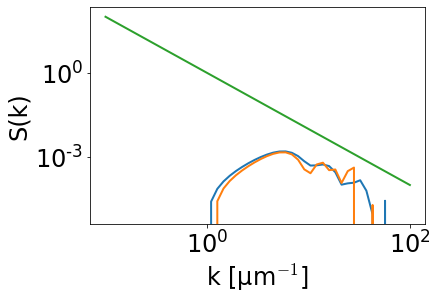

In [31]:
_ = plt.loglog(tkx_arr[:, 0].cpu(), Sx_avg)
# _ = plt.loglog(tky_arr[:,1].cpu(), Sy_avg)
_ = plt.loglog(tkz_arr[:, 2].cpu(), Sz_avg)
# _ = plt.loglog(tkx_arr[:,0].cpu(), (Sx_avg + Sy_avg + Sz_avg)/3.)
_ = plt.loglog(tkx_arr[:, 0].cpu(), (1.0 / tkx_arr[:, 0] ** 2).cpu())

_ = plt.xlabel("k [μm$^{-1}$]")
_ = plt.ylabel("S(k)")

In [52]:
main_test_dir = Path("/mnt/home/alamson/ceph/DATA/Motor_Inference/IsoNemTesting")
data_files = list(main_test_dir.glob("**/analysis/nematic_analysis.h5"))
for i, dfile in enumerate(data_files):
    print(i, dfile)

0 /mnt/home/alamson/ceph/DATA/Motor_Inference/IsoNemTesting/NemN8000ld5rho.4dte-5/analysis/nematic_analysis.h5
1 /mnt/home/alamson/ceph/DATA/Motor_Inference/IsoNemTesting/NemN8000ld5rho.4dte-5/simulations/dt0.0001/analysis/nematic_analysis.h5
2 /mnt/home/alamson/ceph/DATA/Motor_Inference/IsoNemTesting/NemN8000ld5rho.4dte-5/simulations/dt0.001/analysis/nematic_analysis.h5
3 /mnt/home/alamson/ceph/DATA/Motor_Inference/IsoNemTesting/NemN8000ld5rho.4dte-5/simulations/dt1e-05/analysis/nematic_analysis.h5
4 /mnt/home/alamson/ceph/DATA/Motor_Inference/IsoNemTesting/NemN8000ld5rho.4dte-5/simulations/dt0.01/analysis/nematic_analysis.h5
5 /mnt/home/alamson/ceph/DATA/Motor_Inference/IsoNemTesting/NemN8000ld10rho.45/simulations/dt0.0001/analysis/nematic_analysis.h5
6 /mnt/home/alamson/ceph/DATA/Motor_Inference/IsoNemTesting/NemN8000ld10rho.45/simulations/dt0.001/analysis/nematic_analysis.h5
7 /mnt/home/alamson/ceph/DATA/Motor_Inference/IsoNemTesting/NemN8000ld10rho.45/simulations/dt1e-05/analysis/

Everthing is initially aligned in the z-axis.

/mnt/home/alamson/ceph/DATA/Motor_Inference/IsoNemTesting/NemN8000ld5rho.5dte-5/simulations/dt1e-05/analysis/nematic_analysis.h5


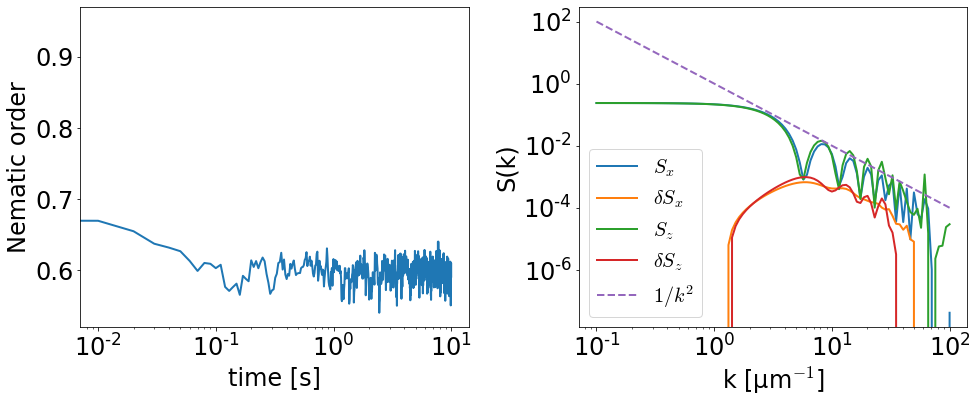

In [19]:
k_points = 100
main_test_dir = Path("/mnt/home/alamson/ceph/DATA/Motor_Inference/IsoNemTesting")
data_files = list(main_test_dir.glob("**/analysis/nematic_analysis.h5"))
data_ind = 11
with h5py.File(data_files[data_ind], "r") as h5_data:
    print(data_files[data_ind])
    order = h5_data["nematic_order"][...]
    time_arr = h5_data["time"][...]
    Sx_arr = h5_data["nematic_structure_x"][...]
    dSx_arr = h5_data["nematic_fluctuation_x"][...]
    Sz_arr = h5_data["nematic_structure_z"][...]
    dSz_arr = h5_data["nematic_fluctuation_z"][...]
    tk_arr = torch.logspace(-1, 2, k_points)

fig, axarr = plt.subplots(1,2, figsize=(14,6))

_ = axarr[0].semilogx(time_arr, order)
_ = axarr[0].set_ylabel('Nematic order')
_ = axarr[0].set_xlabel('time [s]')

_ = axarr[1].loglog(tk_arr, Sx_arr.mean(axis=1), label="$S_x$")
_ = axarr[1].loglog(tk_arr, dSx_arr.mean(axis=1), label="$\delta S_x$")
_ = axarr[1].loglog(tk_arr, Sz_arr.mean(axis=1), label="$S_z$")
_ = axarr[1].loglog(tk_arr, dSz_arr.mean(axis=1), label="$\delta S_z$")
# _ = plt.loglog(tky_arr[:,1].cpu(), Sy_avg)
# _ = plt.loglog(tkz_arr[:, 2].cpu(), Sz_avg, label="$\delta S_z$")
# _ = plt.loglog(
#     tkx_arr[:, 0].cpu(), (Sx_avg + Sy_avg + Sz_avg) / 3.0, label="$\delta S_{avg}$"
# )
_ = axarr[1].loglog(
    tk_arr,
     (1.0 / (tk_arr ** 2)),
    label="$1/k^2$",
    linestyle="--",
)

_ = axarr[1].set_xlabel("k [μm$^{-1}$]")
_ = axarr[1].set_ylabel("S(k)")
_ = axarr[1].legend()
fig.tight_layout()

/mnt/home/alamson/ceph/DATA/Motor_Inference/IsoNemTesting/NemN8000ld10rho.45/simulations/dt1e-05/analysis/nematic_analysis.h5


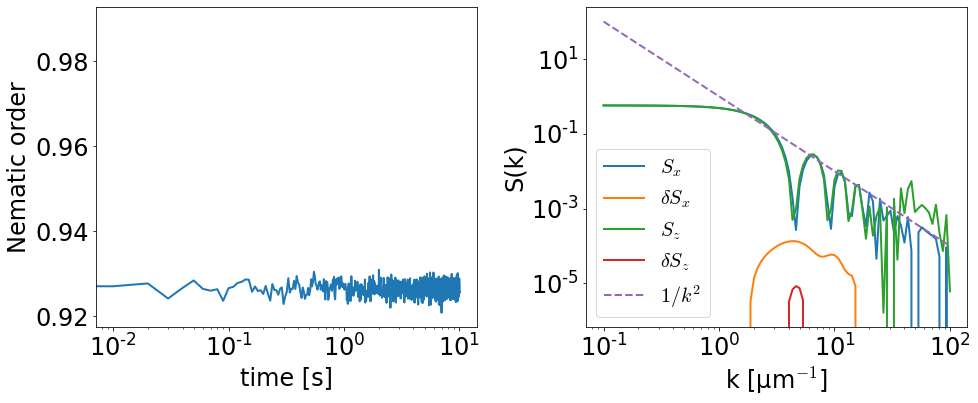

In [18]:
k_points = 100
main_test_dir = Path("/mnt/home/alamson/ceph/DATA/Motor_Inference/IsoNemTesting")
data_files = list(main_test_dir.glob("**/analysis/nematic_analysis.h5"))
data_ind = 7
with h5py.File(data_files[data_ind], "r") as h5_data:
    print(data_files[data_ind])
    order = h5_data["nematic_order"][...]
    time_arr = h5_data["time"][...]
    Sx_arr = h5_data["nematic_structure_x"][...]
    dSx_arr = h5_data["nematic_fluctuation_x"][...]
    Sz_arr = h5_data["nematic_structure_z"][...]
    dSz_arr = h5_data["nematic_fluctuation_z"][...]
    tk_arr = torch.logspace(-1, 2, k_points)

fig, axarr = plt.subplots(1,2, figsize=(14,6))

_ = axarr[0].semilogx(time_arr, order)
_ = axarr[0].set_ylabel('Nematic order')
_ = axarr[0].set_xlabel('time [s]')

_ = axarr[1].loglog(tk_arr, Sx_arr.mean(axis=1), label="$S_x$")
_ = axarr[1].loglog(tk_arr, dSx_arr.mean(axis=1), label="$\delta S_x$")
_ = axarr[1].loglog(tk_arr, Sz_arr.mean(axis=1), label="$S_z$")
_ = axarr[1].loglog(tk_arr, dSz_arr.mean(axis=1), label="$\delta S_z$")
# _ = plt.loglog(tky_arr[:,1].cpu(), Sy_avg)
# _ = plt.loglog(tkz_arr[:, 2].cpu(), Sz_avg, label="$\delta S_z$")
# _ = plt.loglog(
#     tkx_arr[:, 0].cpu(), (Sx_avg + Sy_avg + Sz_avg) / 3.0, label="$\delta S_{avg}$"
# )
_ = axarr[1].loglog(
    tk_arr,
     (1.0 / (tk_arr ** 2)),
    label="$1/k^2$",
    linestyle="--",
)

_ = axarr[1].set_xlabel("k [μm$^{-1}$]")
_ = axarr[1].set_ylabel("S(k)")
_ = axarr[1].legend()
fig.tight_layout()

/mnt/home/alamson/ceph/DATA/Motor_Inference/IsoNemTesting/NemN8000ld5rho.4dte-5/simulations/dt1e-05/analysis/nematic_analysis.h5


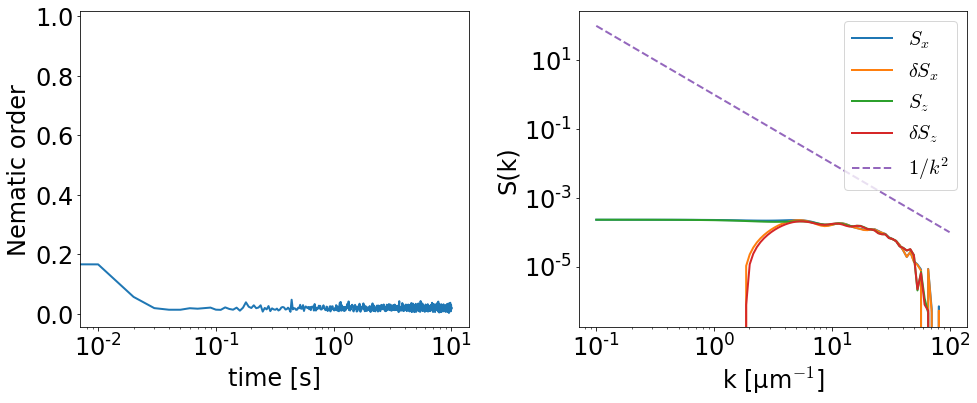

In [20]:
k_points = 100
main_test_dir = Path("/mnt/home/alamson/ceph/DATA/Motor_Inference/IsoNemTesting")
data_files = list(main_test_dir.glob("**/analysis/nematic_analysis.h5"))
data_ind = 3
with h5py.File(data_files[data_ind], "r") as h5_data:
    print(data_files[data_ind])
    order = h5_data["nematic_order"][...]
    time_arr = h5_data["time"][...]
    Sx_arr = h5_data["nematic_structure_x"][...]
    dSx_arr = h5_data["nematic_fluctuation_x"][...]
    Sz_arr = h5_data["nematic_structure_z"][...]
    dSz_arr = h5_data["nematic_fluctuation_z"][...]
    tk_arr = torch.logspace(-1, 2, k_points)

fig, axarr = plt.subplots(1,2, figsize=(14,6))

_ = axarr[0].semilogx(time_arr, order)
_ = axarr[0].set_ylabel('Nematic order')
_ = axarr[0].set_xlabel('time [s]')

_ = axarr[1].loglog(tk_arr, Sx_arr.mean(axis=1), label="$S_x$")
_ = axarr[1].loglog(tk_arr, dSx_arr.mean(axis=1), label="$\delta S_x$")
_ = axarr[1].loglog(tk_arr, Sz_arr.mean(axis=1), label="$S_z$")
_ = axarr[1].loglog(tk_arr, dSz_arr.mean(axis=1), label="$\delta S_z$")
# _ = plt.loglog(tky_arr[:,1].cpu(), Sy_avg)
# _ = plt.loglog(tkz_arr[:, 2].cpu(), Sz_avg, label="$\delta S_z$")
# _ = plt.loglog(
#     tkx_arr[:, 0].cpu(), (Sx_avg + Sy_avg + Sz_avg) / 3.0, label="$\delta S_{avg}$"
# )
_ = axarr[1].loglog(
    tk_arr,
     (1.0 / (tk_arr ** 2)),
    label="$1/k^2$",
    linestyle="--",
)

_ = axarr[1].set_xlabel("k [μm$^{-1}$]")
_ = axarr[1].set_ylabel("S(k)")
_ = axarr[1].legend()
fig.tight_layout()

/mnt/home/alamson/ceph/DATA/Motor_Inference/IsoNemTesting/NemN8000ld10rho.1/simulations/dt1e-05/analysis/nematic_analysis.h5


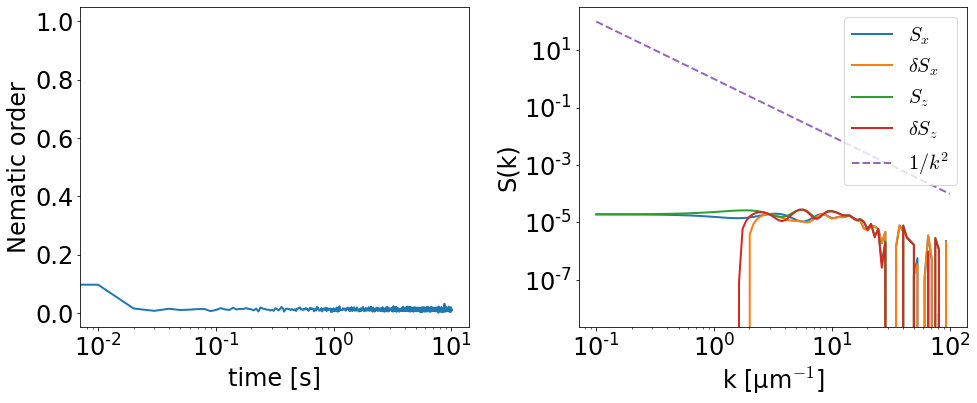

In [21]:
k_points = 100
main_test_dir = Path("/mnt/home/alamson/ceph/DATA/Motor_Inference/IsoNemTesting")
data_files = list(main_test_dir.glob("**/analysis/nematic_analysis.h5"))
data_ind = 15
with h5py.File(data_files[data_ind], "r") as h5_data:
    print(data_files[data_ind])
    order = h5_data["nematic_order"][...]
    time_arr = h5_data["time"][...]
    Sx_arr = h5_data["nematic_structure_x"][...]
    dSx_arr = h5_data["nematic_fluctuation_x"][...]
    Sz_arr = h5_data["nematic_structure_z"][...]
    dSz_arr = h5_data["nematic_fluctuation_z"][...]
    tk_arr = torch.logspace(-1, 2, k_points)

fig, axarr = plt.subplots(1,2, figsize=(14,6))

_ = axarr[0].semilogx(time_arr, order)
_ = axarr[0].set_ylabel('Nematic order')
_ = axarr[0].set_xlabel('time [s]')

_ = axarr[1].loglog(tk_arr, Sx_arr.mean(axis=1), label="$S_x$")
_ = axarr[1].loglog(tk_arr, dSx_arr.mean(axis=1), label="$\delta S_x$")
_ = axarr[1].loglog(tk_arr, Sz_arr.mean(axis=1), label="$S_z$")
_ = axarr[1].loglog(tk_arr, dSz_arr.mean(axis=1), label="$\delta S_z$")
# _ = plt.loglog(tky_arr[:,1].cpu(), Sy_avg)
# _ = plt.loglog(tkz_arr[:, 2].cpu(), Sz_avg, label="$\delta S_z$")
# _ = plt.loglog(
#     tkx_arr[:, 0].cpu(), (Sx_avg + Sy_avg + Sz_avg) / 3.0, label="$\delta S_{avg}$"
# )
_ = axarr[1].loglog(
    tk_arr,
     (1.0 / (tk_arr ** 2)),
    label="$1/k^2$",
    linestyle="--",
)

_ = axarr[1].set_xlabel("k [μm$^{-1}$]")
_ = axarr[1].set_ylabel("S(k)")
_ = axarr[1].legend()
fig.tight_layout()

# Timestep effects

/mnt/home/alamson/ceph/DATA/Motor_Inference/IsoNemTesting/NemN8000ld10rho.45/simulations/dt1e-05/analysis/nematic_analysis.h5
/mnt/home/alamson/ceph/DATA/Motor_Inference/IsoNemTesting/NemN8000ld10rho.45/simulations/dt0.0001/analysis/nematic_analysis.h5
/mnt/home/alamson/ceph/DATA/Motor_Inference/IsoNemTesting/NemN8000ld10rho.45/simulations/dt0.001/analysis/nematic_analysis.h5
/mnt/home/alamson/ceph/DATA/Motor_Inference/IsoNemTesting/NemN8000ld10rho.45/simulations/dt0.01/analysis/nematic_analysis.h5


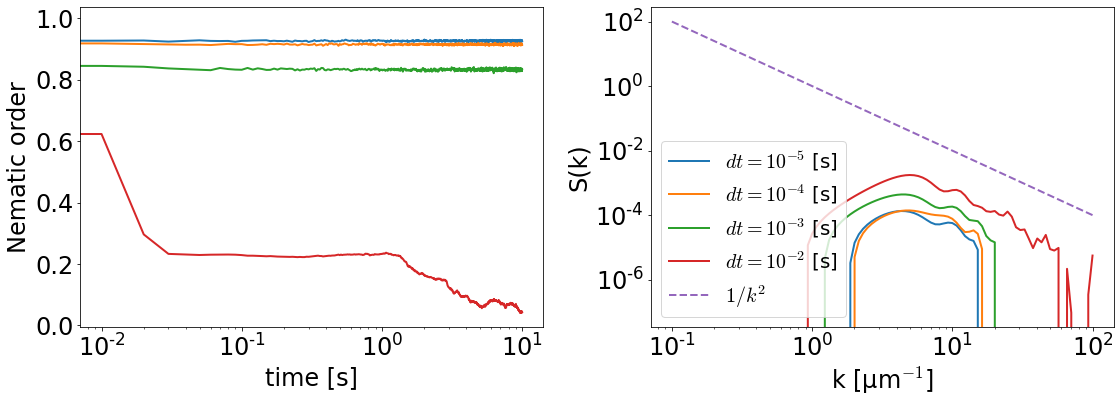

In [31]:
main_test_dir = Path("/mnt/home/alamson/ceph/DATA/Motor_Inference/IsoNemTesting")
data_files = list(main_test_dir.glob("**/analysis/nematic_analysis.h5"))
ind_dict = {'$dt = 10^{-5}$ [s]': 7, '$dt = 10^{-4}$ [s]': 5, '$dt = 10^{-3}$ [s]': 6, '$dt = 10^{-2}$ [s]': 8}

fig, axarr = plt.subplots(1,2, figsize=(16,6))
for key, data_ind in ind_dict.items():
    with h5py.File(data_files[data_ind], "r") as h5_data:
        print(data_files[data_ind])
        order = h5_data["nematic_order"][...]
        time_arr = h5_data["time"][...]
        dSx_arr = h5_data["nematic_fluctuation_x"][...]
        # dSz_arr = h5_data["nematic_fluctuation_z"][...]
        tk_arr = torch.logspace(-1, 2, k_points)


    _ = axarr[0].semilogx(time_arr, order, label=key)
    _ = axarr[0].set_ylabel('Nematic order')
    _ = axarr[0].set_xlabel('time [s]')

    _ = axarr[1].loglog(tk_arr, dSx_arr.mean(axis=1), label=key)
    # _ = axarr[1].loglog(tk_arr, dSz_arr.mean(axis=1), label="$\delta S_z$")
    # _ = plt.loglog(tky_arr[:,1].cpu(), Sy_avg)
    # _ = plt.loglog(tkz_arr[:, 2].cpu(), Sz_avg, label="$\delta S_z$")
    # _ = plt.loglog(
    #     tkx_arr[:, 0].cpu(), (Sx_avg + Sy_avg + Sz_avg) / 3.0, label="$\delta S_{avg}$"
    # )
_ = axarr[1].loglog(
    tk_arr,
    (1.0 / (tk_arr ** 2)),
    label="$1/k^2$",
    linestyle="--",
)

_ = axarr[1].set_xlabel("k [μm$^{-1}$]")
_ = axarr[1].set_ylabel("S(k)")
_ = axarr[1].legend()
fig.tight_layout()

/mnt/home/alamson/ceph/DATA/Motor_Inference/IsoNemTesting/NemN8000ld5rho.5dte-5/simulations/dt1e-05/analysis/nematic_analysis.h5
/mnt/home/alamson/ceph/DATA/Motor_Inference/IsoNemTesting/NemN8000ld5rho.5dte-5/simulations/dt0.0001/analysis/nematic_analysis.h5
/mnt/home/alamson/ceph/DATA/Motor_Inference/IsoNemTesting/NemN8000ld5rho.5dte-5/simulations/dt0.001/analysis/nematic_analysis.h5
/mnt/home/alamson/ceph/DATA/Motor_Inference/IsoNemTesting/NemN8000ld5rho.5dte-5/simulations/dt0.01/analysis/nematic_analysis.h5


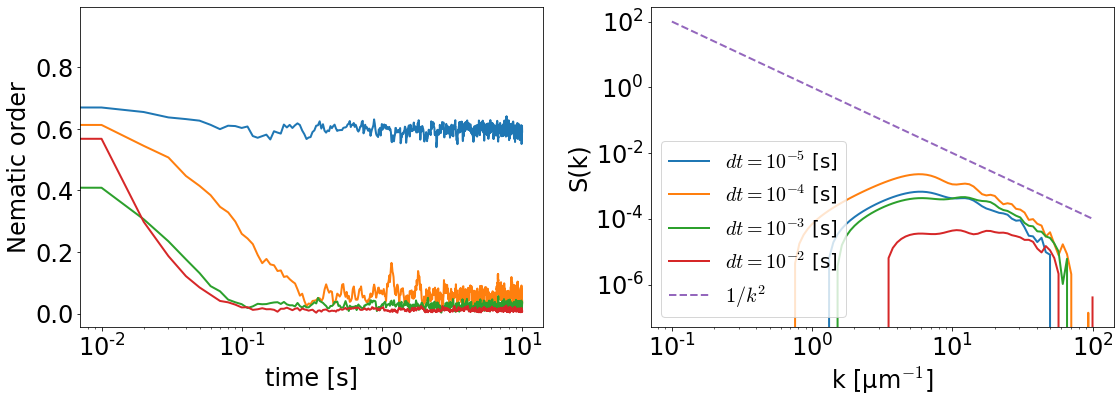

In [29]:
main_test_dir = Path("/mnt/home/alamson/ceph/DATA/Motor_Inference/IsoNemTesting")
data_files = list(main_test_dir.glob("**/analysis/nematic_analysis.h5"))
ind_dict = {'$dt = 10^{-5}$ [s]': 11, '$dt = 10^{-4}$ [s]': 9, '$dt = 10^{-3}$ [s]': 10, '$dt = 10^{-2}$ [s]': 12}

fig, axarr = plt.subplots(1,2, figsize=(16,6))
for key, data_ind in ind_dict.items():
    with h5py.File(data_files[data_ind], "r") as h5_data:
        print(data_files[data_ind])
        order = h5_data["nematic_order"][...]
        time_arr = h5_data["time"][...]
        dSx_arr = h5_data["nematic_fluctuation_x"][...]
        # dSz_arr = h5_data["nematic_fluctuation_z"][...]
        tk_arr = torch.logspace(-1, 2, k_points)


    _ = axarr[0].semilogx(time_arr, order, label=key)
    _ = axarr[0].set_ylabel('Nematic order')
    _ = axarr[0].set_xlabel('time [s]')

    _ = axarr[1].loglog(tk_arr, dSx_arr.mean(axis=1), label=key)
    # _ = axarr[1].loglog(tk_arr, dSz_arr.mean(axis=1), label="$\delta S_z$")
    # _ = plt.loglog(tky_arr[:,1].cpu(), Sy_avg)
    # _ = plt.loglog(tkz_arr[:, 2].cpu(), Sz_avg, label="$\delta S_z$")
    # _ = plt.loglog(
    #     tkx_arr[:, 0].cpu(), (Sx_avg + Sy_avg + Sz_avg) / 3.0, label="$\delta S_{avg}$"
    # )
_ = axarr[1].loglog(
    tk_arr,
    (1.0 / (tk_arr ** 2)),
    label="$1/k^2$",
    linestyle="--",
)

_ = axarr[1].set_xlabel("k [μm$^{-1}$]")
_ = axarr[1].set_ylabel("S(k)")
# _ = axarr[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
_ = axarr[1].legend()
fig.tight_layout()

# New testing

In [85]:
k_points= 400
n_time_points= 100
ts_start= 100

tk_arr = torch.logspace(-0.5, 2.5, k_points)
tkx_arr = torch.vstack([tk_arr, torch.zeros(k_points), torch.zeros(k_points)]).T.to(
    device
)
tky_arr = torch.vstack([torch.zeros(k_points), tk_arr, torch.zeros(k_points)]).T.to(
    device
)
tkz_arr = torch.vstack([torch.zeros(k_points), torch.zeros(k_points), tk_arr]).T.to(
    device
)

com_arr = 0.5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
tcom_arr = torch.from_numpy(com_arr).to(device)
dir_arr = sy_dat[:, 5:8, :] - sy_dat[:, 2:5, :]
tdir_arr = torch.from_numpy(dir_arr).to(device)

time_step = (len(time_arr) - ts_start) // n_time_points

# Full Q-tensor structure factor
# timer.milestone()
Sx_time_arr = torch.zeros((k_points, n_time_points)).to(device)
Sy_time_arr = torch.zeros((k_points, n_time_points)).to(device)
Sz_time_arr = torch.zeros((k_points, n_time_points)).to(device)

for i in range(n_time_points):
    time_ind = ts_start + i * time_step
    tdir = tdir_arr[:, :, time_ind]
    tcom = tcom_arr[:, :, time_ind]

    # tQ_arr = aa.nematic_order.make_nematic_tensor_arr(tdir, device)
    # tQ_arr = torch.complex(tQ_arr, torch.zeros_like(tQ_arr))

    Sx_time_arr[:, i] = aa.nematic_order.make_structure_factor_torch_fast(
         tcom, tkx_arr, device=device
    )
    Sy_time_arr[:, i] = aa.nematic_order.make_structure_factor_torch_fast(
        tcom, tky_arr, device=device
    )
    Sz_time_arr[:, i] = aa.nematic_order.make_structure_factor_torch_fast(
        tcom, tkz_arr, device=device
    )

[1.08 1.08 1.08]


tensor(-0.0002)

tensor(-0.0002)

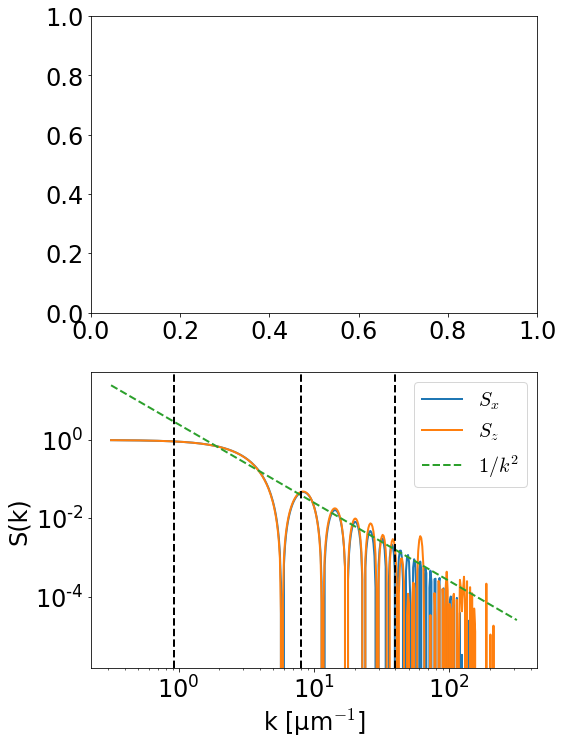

In [91]:
fig, axarr = plt.subplots(2,1, figsize=(8, 12))

box_lower = np.array(param_dict["simBoxLow"])
box_upper = np.array(param_dict["simBoxHigh"])
print(-box_lower+box_upper)

# _ = axarr[1].plot(tk_arr, Sx_time_arr.mean(dim=1).cpu(), label="$ S_x$")
# _ = axarr[1].plot(tk_arr, Sz_time_arr.mean(dim=1).cpu(), label="$ S_z$")

_ = axarr[1].loglog(tk_arr, Sx_time_arr.mean(dim=1).cpu(), label="$ S_x$")
_ = axarr[1].loglog(tk_arr, Sz_time_arr.mean(dim=1).cpu(), label="$ S_z$")

min(Sx_time_arr.mean(dim=1).cpu())
min(Sz_time_arr.mean(dim=1).cpu())

_ = axarr[1].loglog(
    tk_arr,
     (2.5 / (tk_arr ** 2)),
    label="$1/k^2$",
    linestyle="--",
)

_ = axarr[1].axvline(x=1./(.025), color="k", linestyle="--")
_ = axarr[1].axvline(x=1./(.125), color="k", linestyle="--")
_ = axarr[1].axvline(x=1./(1.08), color="k", linestyle="--")
# for i in range(1, 5):
#  _ = axarr[1].axvline(x=1./(.0125*i), color="k", linestyle="--")

_ = plt.xlabel("k [μm$^{-1}$]")
_ = plt.ylabel("S(k)")
_ = plt.legend()

In [32]:
k_points= 400
n_time_points= 100
ts_start= 100

tk_arr = torch.logspace(-0.5, 1.5, k_points)
tkx_arr = torch.vstack([tk_arr, torch.zeros(k_points), torch.zeros(k_points)]).T.to(
    device
)
tky_arr = torch.vstack([torch.zeros(k_points), tk_arr, torch.zeros(k_points)]).T.to(
    device
)
tkz_arr = torch.vstack([torch.zeros(k_points), torch.zeros(k_points), tk_arr]).T.to(
    device
)
# Randomly distribute 8000 points in a box 1.08 x 1.08 x 1.08


n_points = 16000
box_size = 5.08
# Generate 8000 random points in a box of size 1.08 x 1.08 x 1.08
tcom_arr = torch.rand(n_points, 3,1000).to(device) * box_size

time_step = (len(time_arr) - ts_start) // n_time_points

# Full Q-tensor structure factor
# timer.milestone()
Sx_time_arr = torch.zeros((k_points, n_time_points)).to(device)
Sy_time_arr = torch.zeros((k_points, n_time_points)).to(device)
Sz_time_arr = torch.zeros((k_points, n_time_points)).to(device)

for i in range(n_time_points):
    time_ind = ts_start + i * time_step
    tcom = tcom_arr[:, :, time_ind]

    # tQ_arr = aa.nematic_order.make_nematic_tensor_arr(tdir, device)
    # tQ_arr = torch.complex(tQ_arr, torch.zeros_like(tQ_arr))

    Sx_time_arr[:, i] = aa.nematic_order.make_structure_factor_torch_fast(
         tcom, tkx_arr, device=device
    )
    Sy_time_arr[:, i] = aa.nematic_order.make_structure_factor_torch_fast(
        tcom, tky_arr, device=device
    )
    Sz_time_arr[:, i] = aa.nematic_order.make_structure_factor_torch_fast(
        tcom, tkz_arr, device=device
    )

/mnt/home/alamson/projects/analysis/aLENS_analysis/alens_analysis/nematic_order.py:217: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /opt/conda/conda-bld/pytorch_1666642975312/work/aten/src/ATen/native/Copy.cpp:250.)
  S_arr[cur_ind : cur_ind + S.shape[-1]] = S / (tr_arr.shape[0] ** 2)


[1.16 1.16 1.16]


tensor(-6.6016e-05)

tensor(-7.1149e-05)

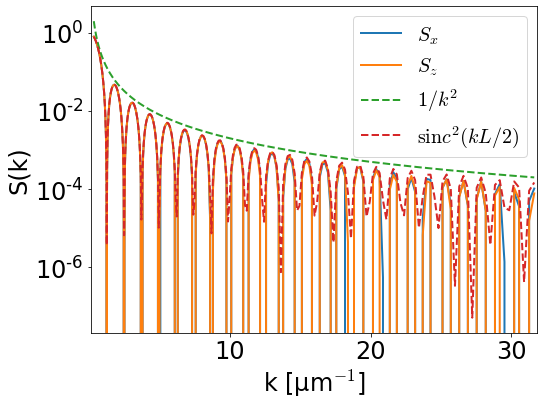

In [45]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))

box_lower = np.array(param_dict["simBoxLow"])
box_upper = np.array(param_dict["simBoxHigh"])
print(-box_lower+box_upper)

_ = axarr.semilogy(tk_arr, Sx_time_arr.mean(dim=1).cpu(), label="$ S_x$")
_ = axarr.semilogy(tk_arr, Sz_time_arr.mean(dim=1).cpu(), label="$ S_z$")

min(Sx_time_arr.mean(dim=1).cpu())
min(Sz_time_arr.mean(dim=1).cpu())

_ = axarr.semilogy(
    tk_arr,
     (.2 / (tk_arr ** 2)),
    label="$1/k^2$",
    linestyle="--",
)

_ = axarr.semilogy(
    tk_arr,
     (torch.sin(tk_arr*5.08/2.)**2 / ((5.08*.5*tk_arr) ** 2)),
    label="$\sinc^2(kL/2)$",
    linestyle="--",
)

_ = axarr.set_xlim(0.1, 100/np.pi)

_ = axarr.set_xlabel("k [μm$^{-1}$]")
_ = axarr.set_ylabel("S(k)")
_ = axarr.legend()